# Debugging MRMS Forcing 

In [1]:
%matplotlib widget

In [2]:
#import multiprocessing.popen_spawn_posix
from dask.distributed import Client

# instantiate the Dask dashboard interface
Client()  

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 12,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:56695,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:56708,Total threads: 3
Dashboard: http://127.0.0.1:56715/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:56700,


In [3]:
import os
from glob import glob
import numpy
import xarray
import pandas
import folium
import jenkspy
import geopandas
from tqdm import tqdm
from datetime import datetime
import matplotlib.pyplot as plt
from pynhd import NLDI, WaterData, NHDPlusHR

## 1. Load WRF-Hydro Data

In [4]:
output_idealized_dir = '../simulation-debugging/OUTPUT-idealized'
output_idealized_mrms_dir = '../simulation-debugging/OUTPUT-idealized-mrms'

Merge channel routing output into a single file to speed up loading time.

In [5]:
files = glob(f'{output_idealized_mrms_dir}/*CHRTOUT*')
ideal_mrms = xarray.open_mfdataset(files, parallel=True)

In [6]:
files = glob(f'{output_idealized_dir}/*CHRTOUT*')
ideal = xarray.open_mfdataset(files, parallel=True)


## Plot Idealized and Idealized+MRMS

We expect the output to be different between these runs.

> Idealized: This option is the most simple method to force the model and requires no
input files. A simple rainfall event is prescribed (i.e. ‘hardwired’) in the model of 25.4
inches per hour (1 inch per hour) for 1 hour duration. The event starts on timestep (hour)
The rest of the forcing data variables are set to have either constant values (in space and
time) or, in the case of temperature and radiation variables, a fixed diurnal cycle. This
option is mainly used for simple testing of the model and is convenient for checking
whether or not components besides the forcing data are properly being read into the
model and working. Version 1.0 of WRF-Hydro has hardwired values of these forcing
data terms. Future version will allow the user to input default values for the precipitation
event and the other meteorological variables.

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
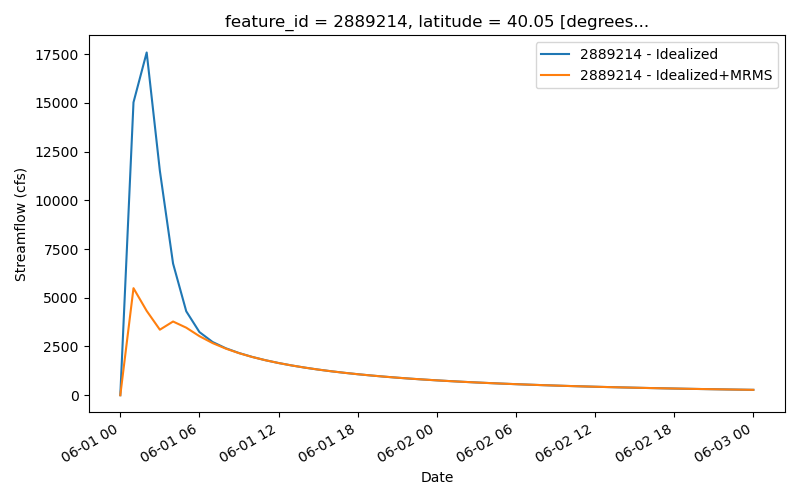

In [7]:
fig = plt.figure(figsize=(8, 5))
ax = plt.gca()

link = 2889214
(ideal.sel(feature_id=int(link)).streamflow * 35.314666212661).plot(ax=ax, label=f'{link} - Idealized')
(ideal_mrms.sel(feature_id=int(link)).streamflow * 35.314666212661).plot(ax=ax, label=f'{link} - Idealized+MRMS')
                                                                                                                                                    
# finish configuring the plot
ax.set_ylabel('Streamflow (cfs)')
ax.set_xlabel('Date')
_ = ax.legend()

fig.autofmt_xdate()
plt.tight_layout()
        

## Plot Simulation Results: HR-LDAS vs HR-LDAS+MRMS

In [8]:
hrldas_dir = '../simulation-debugging/OUTPUT-hrldas'
mrms_dir = '../simulation-debugging/OUTPUT-mrms'

In [9]:
files = glob(f'{hrldas_dir}/*CHRTOUT*')
hrldas = xarray.open_mfdataset(files, parallel=True)

In [10]:
files = glob(f'{mrms_dir}/*CHRTOUT*')
mrms = xarray.open_mfdataset(files, parallel=True)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
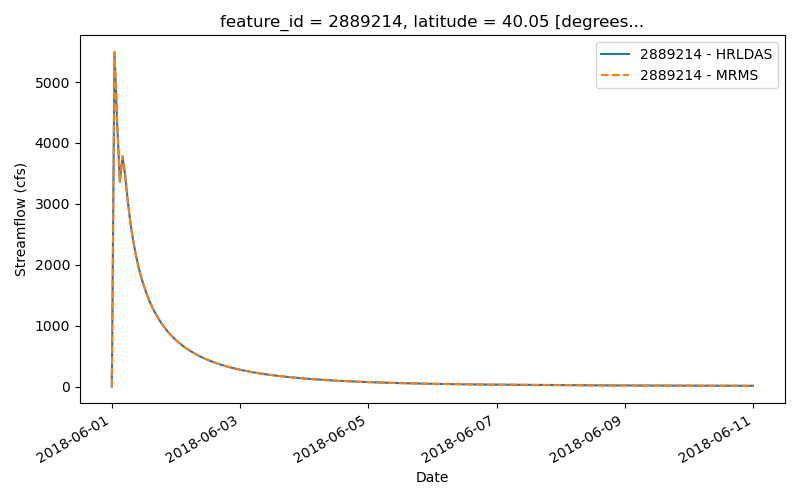

In [11]:
fig = plt.figure(figsize=(8, 5))
ax = plt.gca()

link = 2889214
(hrldas.sel(feature_id=int(link)).streamflow * 35.314666212661).plot(ax=ax, label=f'{link} - HRLDAS')
(mrms.sel(feature_id=int(link)).streamflow * 35.314666212661).plot(ax=ax, label=f'{link} - MRMS', linestyle='--')
                                                                                                                                                    
# finish configuring the plot
ax.set_ylabel('Streamflow (cfs)')
ax.set_xlabel('Date')
_ = ax.legend()

fig.autofmt_xdate()
plt.tight_layout()

## Inspect HR-LDAS and MRMS Forcing

In [4]:
import re

In [6]:
mrms = glob('../FORCING/*PRECIP_FORCING.nc')
nldas = glob('../FORCING/*LDASIN_DOMAIN1')

In [8]:
#r = re.compile(".*201806[0|1][0-11].*")
#mrms_forc = xarray.open_mfdataset(list(filter(r.match, mrms)), concat_dim='Times', combine='nested',  parallel=True)
#hrldas_forc = xarray.open_mfdataset(list(filter(r.match, nldas)), concat_dim='Times', combine='nested',  parallel=True)

mrms_forc = xarray.open_mfdataset(mrms[0:300], concat_dim='Times', combine='nested',  parallel=True)
hrldas_forc = xarray.open_mfdataset(nldas[0:300], concat_dim='Times', combine='nested',  parallel=True)

In [9]:
# convert Times into datetime objects
timeindex = mrms_forc['Times'].values.astype(str)
timeindex = [t.replace('_', ' ') for t in timeindex]
mrms_forc['Times'] = pandas.DatetimeIndex(timeindex)

In [10]:
# convert Times into datetime objects
timeindex = hrldas_forc['Times'].values.astype(str)
timeindex = [t.replace('_', ' ') for t in timeindex]
hrldas_forc['Times'] = pandas.DatetimeIndex(timeindex)

In [11]:
mrms_forc = mrms_forc.isel(Time=0)
hrldas_forc = hrldas_forc.isel(Time=0)

In [12]:
# resample temporally (daily) - average rain rate temporally
mrms_forc_1d = mrms_forc.precip_rate.resample(Times='1D').mean()
hrldas_forc_1d = hrldas_forc.RAINRATE.resample(Times='1D').mean()

In [13]:
# spatially average per timestep - average the rain rate spatially
ts_mean_rate_mrms = mrms_forc_1d.mean(dim=['south_north', 'west_east']).values
ts_mean_rate_hrldas = hrldas_forc_1d.mean(dim=['south_north', 'west_east']).values

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
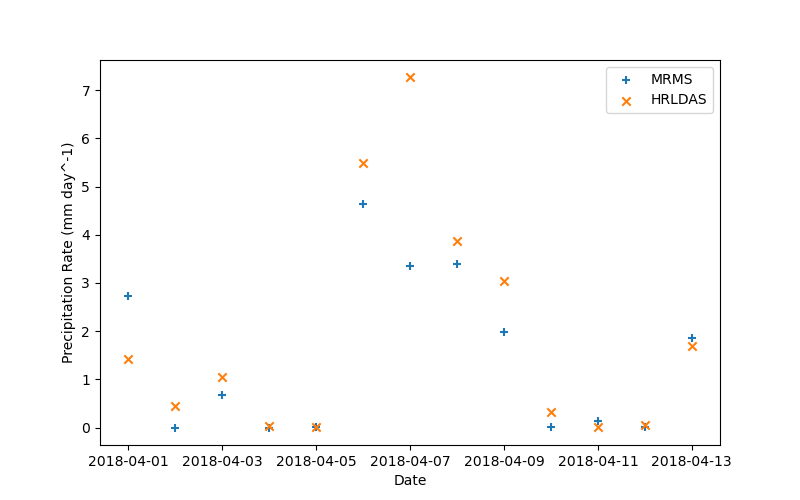

In [20]:
fig = plt.figure(figsize=(8, 5))
ax = plt.gca()

# precip_rate:units = "mm s^-1"
mrms_total_p = ts_mean_rate_mrms * 86400
hrldas_total_p = ts_mean_rate_hrldas * 86400

ax.scatter(mrms_forc_1d.Times.values, mrms_total_p, marker='+', label='MRMS')
ax.scatter(hrldas_forc_1d.Times.values, hrldas_total_p, marker='x', label='HRLDAS')
#ts_mean_rate_mrms.plot(ax=ax)

ax.set_ylabel('Precipitation Rate (mm day^-1)')
ax.set_xlabel('Date')

_ = ax.legend()

In [21]:
list(hrldas_total_p)

[1.4297866775426502,
 0.438031228364292,
 1.0454213830927928,
 0.040632804767594066,
 0.0007296195756580304,
 5.487602653252077,
 7.2643223329819095,
 3.872585467682814,
 3.0465291147678806,
 0.31308029682902144,
 0.004324870231933293,
 0.050516358438370455,
 1.6931104074040637]

Text(0, 0.5, 'Precipitation Rate (mm day^-1)')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
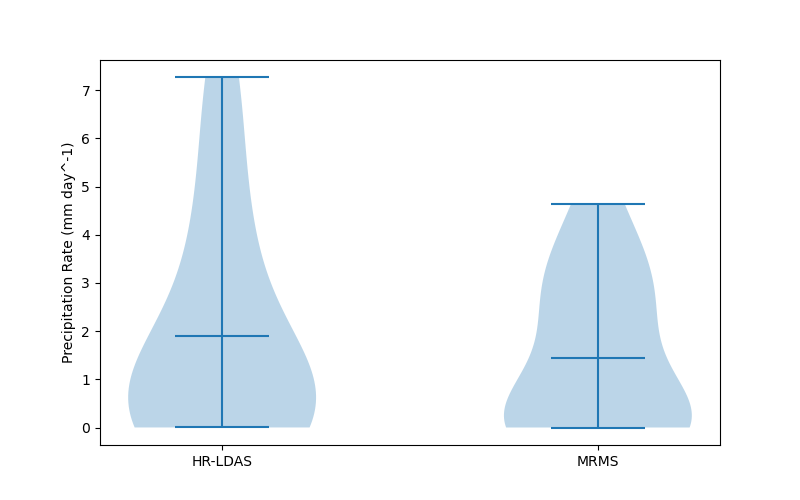

In [22]:
fig = plt.figure(figsize=(8, 5))
ax = plt.gca()

# precip_rate:units = "mm s^-1"
mrms_total_p = ts_mean_rate_mrms * 86400
hrldas_total_p = ts_mean_rate_hrldas * 86400

ax.violinplot([hrldas_total_p, mrms_total_p], [0, 1], showmeans=True)

ax.set_xticks([0, 1])
ax.set_xticklabels(['HR-LDAS', 'MRMS'])
ax.set_ylabel('Precipitation Rate (mm day^-1)')


### Plot MRMS spatially

In [36]:
import animatplot as amp
import matplotlib.pyplot as plt
import hvplot.xarray

In [16]:
mrms_forc = ds = xarray.open_mfdataset(mrms, concat_dim='Times', combine='nested', parallel=True)

# convert Times into datetime objects
timeindex = ds['Times'].values.astype(str)
timeindex = [t.replace('_', ' ') for t in timeindex]
ds['Times'] = pandas.DatetimeIndex(timeindex)

In [87]:
dp = ds.isel(Times=slice(0,5))

In [88]:
dpp = dp.assign_coords({'lat':dp.lat, 'lon':dp.lon})

In [90]:
# set constant colorbar limits
dpp.precip_rate.hvplot.quadmesh(
    x='lon',
    y='lat',
    groupby="Times",  # adds a widget for time
    clim=(250, 295),  # sets colormap limits
    widget_type="scrubber",
    widget_location="bottom",
)


Column
    [0] HoloViews(DynamicMap, widget_location='bottom', widget_type='scrubber')
    [1] Row
        [0] HSpacer()
        [1] WidgetBox
            [0] Player(end=4, width=550)
        [2] HSpacer()

In [138]:
daily

<xarray.Dataset>
Dimensions:      (Times: 183, south_north: 34, west_east: 64)
Coordinates:
  * Times        (Times) datetime64[ns] 2018-04-01 2018-04-02 ... 2018-09-30
    lat          (Times, south_north, west_east) float32 dask.array<chunksize=(1, 34, 64), meta=np.ndarray>
    lon          (Times, south_north, west_east) float32 dask.array<chunksize=(1, 34, 64), meta=np.ndarray>
Dimensions without coordinates: south_north, west_east
Data variables:
    precip_rate  (Times, south_north, west_east) float64 dask.array<chunksize=(1, 34, 64), meta=np.ndarray>

In [106]:
#daily = ds.assign_coords(dict(lat=ds.lat, lon=ds.lon))

In [133]:
# resample the data to daily timestep
daily = ds.precip_rate.resample(Times='1D', restore_coord_dims=True).mean().to_dataset()

In [135]:
daily = daily.assign_coords(dict(lat=ds.lat, lon=ds.lon))

In [137]:
# clean dimensions
daily = daily.squeeze(dim='Time')
#daily = daily.rename({'south_north': 'y', 'west_east':'x'})

In [139]:
st = '2018-04-01'
et = '2018-04-20'
#ds.sel(time=slice('2000-06-01', '2000-06-10'))

In [140]:
#dp = daily_precip_rate.isel(Times=slice(0, 5))
dp = daily.sel(Times=slice(st, et))

distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


Traceback (most recent call last):
 File "/Users/castro/miniconda2/envs/nwm-analysis/lib/python3.9/site-packages/pyviz_comms/__init__.py", line 325, in _handle_msg
 self._on_msg(msg)
 File "/Users/castro/miniconda2/envs/nwm-analysis/lib/python3.9/site-packages/panel/viewable.py", line 273, in _on_msg
 doc.unhold()
 File "/Users/castro/miniconda2/envs/nwm-analysis/lib/python3.9/site-packages/bokeh/document/document.py", line 799, in unhold
 self.callbacks.unhold()
 File "/Users/castro/miniconda2/envs/nwm-analysis/lib/python3.9/site-packages/bokeh/document/callbacks.py", line 396, in unhold
 self.trigger_on_change(event)
 File "/Users/castro/miniconda2/envs/nwm-analysis/lib/python3.9/site-packages/bokeh/document/callbacks.py", line 373, in trigger_on_change
 invoke_with_curdoc(doc, event.callback_invoker)
 File "/Users/castro/miniconda2/envs/nwm-analysis/lib/python3.9/site-packages/bokeh/document/callbacks.py", line 408, in invoke_with_curdoc
 return f()
 File "/Users/castro/miniconda2/envs/nwm-analysis/lib/python3.9/site-packages/bokeh/util/callback_manager.py", line 191, in invoke
 callback(attr, old, new)
 File "/Users/castro/miniconda2/envs/nwm-analysis/lib/python3.9/site-packages/panel/reactive.py", line 301, in _comm_change
 self._process_events({attr: new})
 File "/Users/castro/miniconda2/envs/nwm-analysis/lib/python3.9/site-packages/panel/reactive.py", line 262, in _process_events
 self.param.set_param(**self_events)
 File "/Users/castro/miniconda2/envs/nwm-analysis/lib/python3.9/site-packages/param/parameterized.py", line 1904, in set_param
 return self_.update(kwargs)
 File "/Users/castro/miniconda2/envs/nwm-analysis/lib/python3.9/site-packages/param/parameterized.py", line 1877, in update
 self_._batch_call_watchers()
 File "/Users/castro/miniconda2/envs/nwm-analysis/lib/python3.9/site-packages/param/parameterized.py", line 2038, in _batch_call_watchers
 self_._execute_watcher(watcher, events)
 File "/Users/castro/miniconda2/envs/nwm-analysis/lib/python3.9/site-packages/param/parameterized.py", line 2000, in _execute_watcher
 watcher.fn(*args, **kwargs)
 File "/Users/castro/miniconda2/envs/nwm-analysis/lib/python3.9/site-packages/panel/param.py", line 750, in _replace_pane
 new_object = self.eval(self.object)
 File "/Users/castro/miniconda2/envs/nwm-analysis/lib/python3.9/site-packages/panel/param.py", line 740, in eval
 return function(*args, **kwargs)
 File "/Users/castro/miniconda2/envs/nwm-analysis/lib/python3.9/site-packages/param/parameterized.py", line 387, in _depends
 return func(*args, **kw)
 File "/Users/castro/miniconda2/envs/nwm-analysis/lib/python3.9/site-packages/hvplot/interactive.py", line 98, in evaluate
 obj = self._transform.apply(ds, keep_index=True, compute=False)
 File "/Users/castro/miniconda2/envs/nwm-analysis/lib/python3.9/site-packages/holoviews/util/transform.py", line 738, in apply
 data = self._apply_fn(dataset, data, fn, fn_name, args,
 File "/Users/castro/miniconda2/envs/nwm-analysis/lib/python3.9/site-packages/holoviews/util/transform.py", line 636, in _apply_fn
 raise e
 File "/Users/castro/miniconda2/envs/nwm-analysis/lib/python3.9/site-packages/holoviews/util/transform.py", line 630, in _apply_fn
 data = method(*args, **kwargs)
 File "/Users/castro/miniconda2/envs/nwm-analysis/lib/python3.9/site-packages/xarray/core/dataarray.py", line 1208, in isel
 variable = self._variable.isel(indexers, missing_dims=missing_dims)
 File "/Users/castro/miniconda2/envs/nwm-analysis/lib/python3.9/site-packages/xarray/core/variable.py", line 1193, in isel
 return self[key]
 File "/Users/castro/miniconda2/envs/nwm-analysis/lib/python3.9/site-packages/xarray/core/variable.py", line 786, in __getitem__
 data = as_indexable(self._data)[indexer]
 File "/Users/castro/miniconda2/envs/nwm-analysis/lib/python3.9/site-packages/xarray/core/indexing.py", line 1220, in __getitem__
 return self.array[key.tuple]
 File "/Users/castro/miniconda2/envs/nwm-analysis/lib/python3.9/site-packages/dask/array/core.py", line 


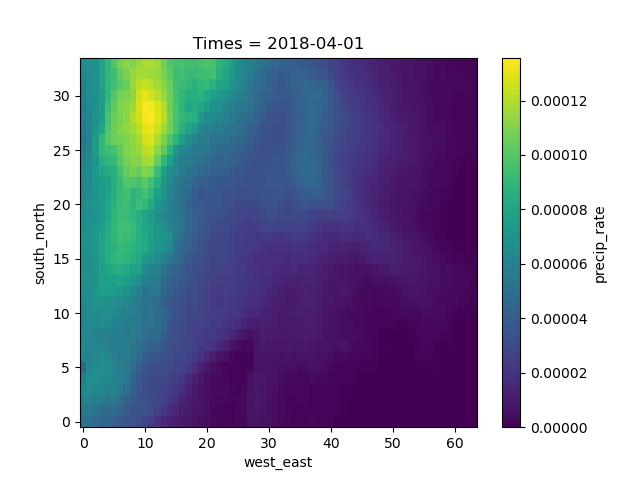

In [147]:
time = pnw.Player(name='time', start=0, end=len(dp.Times), loop_policy='loop', interval=1000)
dp.precip_rate.interactive(loc='bottom').isel(Times=time).plot()

## Compute variance for each timestep